In [1]:
########new dataset
#images
import argparse
import pickle
from torchvision.models import detection
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt 
from PIL import Image
from stacked_hourglass.datasets import generic
import argparse
import glob
from albumentations.core.composition import KeypointParams
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision import transforms
import torch
import numpy as np
from stacked_hourglass.predictor import HumanPosePredictor, GenericPosePredictor
from stacked_hourglass.model import hg2
import cv2
import matplotlib.pyplot as plt
import torch.nn as nn
import csv
import glob
import random
import copy
from PIL import Image
import albumentations as A
from stacked_hourglass.utils import finetune
from stacked_hourglass import train as t
from stacked_hourglass.datasets.mpii import Mpii
from torch.nn import DataParallel
from stacked_hourglass.utils.logger import Logger
import os
from stacked_hourglass.utils.misc import save_checkpoint, adjust_learning_rate
from stacked_hourglass.train import do_training_epoch, do_validation_epoch
import tqdm
import argparse
from stacked_hourglass.datasets.mpii import MPII_JOINT_NAMES
import cv2
from torch.optim.rmsprop import RMSprop
from torch.utils.tensorboard import SummaryWriter
import random

#####################################################################################################
parser = argparse.ArgumentParser(description='Train a stacked hourglass model.')
# Model structure
parser.add_argument('--arch', '-a', metavar='ARCH', default='hg2',
                    choices=['hg1', 'hg2', 'hg8'],
                    help='model architecture')
# Training strategy
parser.add_argument('--input_shape', default=(256, 256), type=int, nargs='+',
                    help='Input shape of the model. Given as: (H, W)')
parser.add_argument('-j', '--workers', default=4, type=int, metavar='N',
                    help='number of data loading workers (default: 4)')
parser.add_argument('--epochs', default=20, type=int, metavar='N',
                    help='number of total epochs to run')
parser.add_argument('--start-epoch', default=0, type=int, metavar='N',
                    help='manual epoch number (useful on restarts)')
parser.add_argument('--train-batch', default=16, type=int, metavar='N',
                    help='train batchsize')
parser.add_argument('--test-batch', default=16, type=int, metavar='N',
                    help='test batchsize')
parser.add_argument('--lr', '--learning-rate', default=2.5e-4, type=float,
                    metavar='LR', help='initial learning rate')
parser.add_argument('--momentum', default=0.9, type=float, metavar='M',
                    help='momentum')
parser.add_argument('--weight-decay', '--wd', default=0, type=float,
                    metavar='W', help='weight decay (default: 0)')
parser.add_argument('--schedule', type=int, nargs='+', default=[200, 201],
                    help='Decrease learning rate at these epochs.')
parser.add_argument('--gamma', type=float, default=0.1,
                    help='LR is multiplied by gamma on schedule.')
# Miscs
parser.add_argument('-c', '--checkpoint', default='checkpoint/', type=str, metavar='PATH',
                    help='path to save checkpoint (default: checkpoint)')
parser.add_argument('--snapshot', default=0, type=int,
                    help='save models for every #snapshot epochs (default: 0)')
parser.add_argument('--resume', default='', type=str, metavar='PATH',
                    help='path to latest checkpoint (default: none)')



_StoreAction(option_strings=['--resume'], dest='resume', nargs=None, const=None, default='', type=<class 'str'>, choices=None, help='path to latest checkpoint (default: none)', metavar='PATH')

In [2]:
#####################################################################################################
args=parser.parse_args(args=[])
final_train_val_data={}
f = glob.glob("C:/Users/mobinamb/Desktop/Mobina work/pytorch pose estimation/transferlearning/pytorch-stacked-hourglass -571t/src/dataset/joints/*.txt")[:-2]
for name in f:
    with open(name,'r') as ff:
        data=ff.readlines()
        for j in range(len(data)):
            keyy=data[j].split()
            valuee1=[]
            for k in range(1,40,2):
                valuee1.append((float(keyy[k]),float(keyy[k+1])))
            name1=name.replace(name[-12:-11],"/")
            b=name1.replace('joints','images/RGB1')
            a='/colorImg'+str(keyy[0])+'.jpg'
            name2=b.replace('.txt',a)
            m1={name2:valuee1}
            final_train_val_data.update(m1)


# set the device we will be using to run the model
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# load the list of categories in the COCO dataset and then generate a
# set of bounding box colors for each class
#CLASSES = pickle.loads(open(args["labels"], "rb").read())
#COLORS = np.random.uniform(0, 255, size=(len(CLASSES), 3))

# initialize a dictionary containing model name and its corresponding 
# torchvision function call
MODELS = {
    "frcnn-resnet": detection.fasterrcnn_resnet50_fpn,
    "frcnn-mobilenet": detection.fasterrcnn_mobilenet_v3_large_320_fpn,
    "retinanet": detection.retinanet_resnet50_fpn
}
# load the model and set it to evaluation mode
model = MODELS["frcnn-resnet"](pretrained=True, progress=True,
    num_classes=91, pretrained_backbone=True).to(DEVICE)
model.eval()


# load the image from disk
'''root='C:/Users/mobinamb/Desktop/Mobina work/pytorch pose estimation/transferlearning/pytorch-stacked-hourglass -571t/src/dataset/images/RGB'
folders=os.listdir(root)
for folder in folders:
    images=os.listdir(root+'/'+folder)
    for ii in range(len(images)):
        image=cv2.imread(root+'/'+folder+'/'+images[ii])

        orig = image.copy()
        # convert the image from BGR to RGB channel ordering and change the
        # image from channels last to channels first ordering
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image.transpose((2, 0, 1))
        # add the batch dimension, scale the raw pixel intensities to the
        # range [0, 1], and convert the image to a floating point tensor
        image = np.expand_dims(image, axis=0)
        image = image / 255.0
        image = torch.FloatTensor(image)
        # send the input to the device and pass the it through the network to
        # get the detections and predictions
        image = image.to(DEVICE)
        detections = model(image)[0]

        idx = int(detections["labels"][0])
        boxx=list(detections.items())[0][1][0]
        (startX, startY, endX, endY) = boxx.detach().cpu().numpy().astype("int")
        #cv2.rectangle(orig, (startX, startY), (endX, endY),
        #    (2,0,0), 2)
        w=endX-startX
        h=endY-startY
        
        if 256-w>0:
            startX=max(0,startX-(256-w)//2)
            endX=min((256-w)//2+endX,orig.shape[1])
        if 256-h>0:
            startY=max(0,startY-(256-h)//2)
            endY=min((256-h)//2+endY,orig.shape[1])
        frame_new=orig[startY:endY,startX:endX]  
        im_pil = Image.fromarray(frame_new) 
        #im_pil.save(root+'1/'+folder+'/'+images[ii])
        if root+'1/'+folder+'/'+images[ii] in list(final_train_val_data.keys()):
            final_train_val_data[root+'1/'+folder+'/'+images[ii]]=[(x-startX,y-startY) for (x,y) in final_train_val_data[root+'1/'+folder+'/'+images[ii]] ]
        #else:
            #os.remove(root+'1/'+folder+'/'+images[ii])
    
#prepare the correct dictionary format of the train-validation dataet {directory of the image:[(x,y) of the joints]}
#create the dataset
#1) save the whole images into a folder in src (dataset/images)
#2) to create a data.npy file (a dictionary consisting of image number as key and its labels (x,y) as values)
#3) create a list of unique random numbers (80%) from the number of image to build train data and (20%) to build validation data
#you can remove train=np.load part of the code as you are spliting the train val data with code from one single dictionary

train,val={},{}
n_train=random.sample(range(1, len(final_train_val_data)), int(0.7*len(final_train_val_data)))
s=list(final_train_val_data.items())
for i in range(len(final_train_val_data)):
    b={s[i][0]:s[i][1]}
    if i in n_train and cv2.imread(s[i][0]) is not None:
        train.update(b)
    elif i not in n_train and cv2.imread(s[i][0]) is not None:
        val.update(b)'''
with open('saved_train.pkl', 'rb') as f:
    train = pickle.load(f)
with open('saved_val.pkl', 'rb') as f1:
    val = pickle.load(f1)      
#####################################################################################################
train_dataset=generic.Generic(train,True)
val_dataset=generic.Generic(val,False)
train_loader= DataLoader(train_dataset,batch_size=args.train_batch, shuffle=True,num_workers=0, pin_memory=True,collate_fn=lambda x: x)
val_loader= DataLoader(val_dataset, batch_size=args.train_batch,shuffle=False,num_workers=0, pin_memory=True,collate_fn=lambda x: x)
#prepare the model
model = hg2(pretrained=True) # first get the base model with 16 outputs
#model=torch.load('model.pth')
# set the pre-trained model's weight untrainable        
for parameter in model.parameters():
        parameter.requires_grad = False 
#change the number of outputs
finetune.change_hg_outputs(model,[None,None,None,9,13,12,15,14,11,10,None,None,3,2,4,1,5,0,None,None])

if torch.cuda.is_available():
            device = torch.device('cuda', torch.cuda.current_device())
            torch.backends.cudnn.benchmark = True
else:
            device = torch.device('cpu')
model = DataParallel(model).to(device)
max_epoch=args.epochs
batch_size=args.train_batch
param_optimizer = list(model.parameters())
from stacked_hourglass.utils import misc
optimiser=torch.optim.Adam(param_optimizer, lr=args.lr,weight_decay=args.weight_decay)
best_acc = 0

#####################################################################################################


In [3]:
#train and eval
lr = args.lr
dic={'train_loss':[],'val_loss':[],'train_acc':[],'val_acc':[],'lr':[],'epoch':[]}
for epoch in range(args.start_epoch,args.epochs):
    lr = adjust_learning_rate(optimiser, epoch, lr, args.schedule, args.gamma)
    # train for one epoch
    batch_size=args.train_batch

    
    train_loss, train_acc = do_training_epoch(train_loader, model, device,optimiser)

    # evaluate on validation set
    valid_loss, valid_acc= do_validation_epoch(val_loader, model, device)
    print('epoch %2d :        Train Loss: %.9f | Valid Loss: %.9f | Train Accuracy: %.3f |  Valid Accuracy: %.3f'%(epoch,train_loss,valid_loss,train_acc,valid_acc))
    
    ############manual show
    dic['train_loss'].append(train_loss*1000)
    dic['val_loss'].append(valid_loss*1000)
    dic['train_acc'].append(train_acc)
    dic['val_acc'].append(valid_acc)
    dic['lr'].append(lr)
    dic['epoch'].append(epoch)

#####################################################################################################
#draw the result with tensorboard
epoch=np.linspace(1,len(dic['lr']),len(dic['lr']))
n=0
plt.subplot(5,1,1)
plt.plot(epoch[n:],dic['train_loss'][n:])
plt.ylabel('train loss')

plt.subplot(5,1,2)
plt.plot(epoch[n:],dic['val_loss'][n:])
plt.ylabel('val loss')

plt.subplot(5,1,4)
plt.plot(epoch[n:],dic['train_acc'][n:])
plt.ylabel('train acc')

plt.subplot(5,1,5)
plt.plot(epoch[n:],dic['val_acc'][n:])
plt.ylabel('val acc')
plt.xlabel('epoch')    

  0%|          | 0/242 [00:00<?, ?it/s, Loss: 0.0003, Acc: 0.6876]

KeyboardInterrupt: 

In [4]:
#torch.save(model,'model.pth')
model=torch.load('model.pth')
print(model)

DataParallel(
  (module): HourglassNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (layer1): Sequential(
      (0): Bottleneck(
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
        )
      )
    )
    (layer2): Sequential(
      (0): Bottleneck(


In [16]:
#heatmap check
# haetmap output of the pre-trained model
#from stacked_hourglass.train import generate_gaussian
from stacked_hourglass.predictor import HumanPosePredictor, GenericPosePredictor
device='cuda'
model1 = hg2(pretrained=True)
model1 = DataParallel(model1).to(device)
input = torch.empty((1,3,256,256), device=device, dtype=torch.float32)
#target = torch.zeros(1,20, 64, 64)
input[0],target,meta=next(iter(train_loader))[1]
#plt.imshow(np.array(input[0].to('cpu').permute(1,2,0)))
with torch.enable_grad():
        # Forward pass and loss calculation.
        output1 = model1(input)
'''for i in range(20):
    plt.subplot(4,5,i+1)
    plt.imshow(output1[0][0,i,:,:].to('cpu').detach().numpy())
plt.show()'''

# haetmap output of the trained model
#input = torch.empty((1,3,256,256), device=device, dtype=torch.float32)
#input[0]=predictor.prepare_image(torch.as_tensor(frame1))

#plt.imshow(np.array(input[0].to('cpu').permute(1,2,0)))

with torch.enable_grad():
        # Forward pass and loss calculation.
        output = model(input)
'''for i in range(20):
    plt.subplot(4,5,i+1)
    plt.imshow(output[0][0,i,:,:].to('cpu').detach().numpy())
    #plt.imshow(target[i].to('cpu').detach().numpy())
plt.show()'''

"for i in range(20):\n    plt.subplot(4,5,i+1)\n    plt.imshow(output[0][0,i,:,:].to('cpu').detach().numpy())\n    #plt.imshow(target[i].to('cpu').detach().numpy())\nplt.show()"

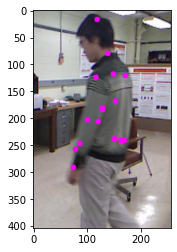

In [11]:
#landmark check
image=cv2.imread('C:/Users/mobinamb/Desktop/Mobina work/pytorch pose estimation/transferlearning/pytorch-stacked-hourglass -571t/src/dataset/images/RGB1/s04_e02/colorImg716.jpg')
#image=cv2.resize(image,(256,256),interpolation = cv2.INTER_AREA)
device='cuda'
frame1 = np.moveaxis(image, -1, 0)
frame2 = torch.as_tensor(np.array(frame1, copy=True))

model = DataParallel(model).to(device)
predictor = HumanPosePredictor(model, device=device)
joints = predictor.estimate_joints(frame2, flip=False)
#image=np.array(input[0].to('cpu').permute(1,2,0))
for i in range(len(joints)):
    #plt.plot(int(joints[i][0]),int(joints[i][1]), color="white", linewidth=5)
    #plt.imshow(image)
    frame=cv2.circle(image,(int(joints[i][0]),int(joints[i][1])),radius=5,color=(255,0,255),thickness=-1) # predicted purple pretrained
plt.imshow(frame)